# Asset Pricing--- Value and Bivariate Sorts

### 本章主要内容
在本章中，我们将单变量投资组合分析扩展到双变量排序，即公司规模与账面市值比，并先后采用独立排序和从属排序的方法形成不同的投资组合，并对其收益率进行比较

### 1. 数据准备
#### 1.1 数据导入
我们从crsp_monthly中获取个股市场数据，从compustat中获取公司会计数据

In [3]:
import pandas as pd
import numpy as np
import os
import sqlite3
import datetime as dt
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format,percent_format
import math
from itertools import product
from joblib import Parallel, delayed, cpu_count

In [4]:
# 从数据库导入数据
tidy_finance = sqlite3.connect(database="tidy_finance_python.sqlite")
crsp_monthly = pd.read_sql_query(sql='SELECT permno, gvkey, month, ret_excess,mktcap, mktcap_lag, exchange FROM crsp_monthly',con=tidy_finance,parse_dates={'month'}).dropna()
crsp_monthly

,permno,gvkey,month,ret_excess,mktcap,mktcap_lag,exchange
0,10028,012096,1993-03-01,-0.102500,6.329250,7.032500,AMEX
1,10028,012096,1993-04-01,0.386489,8.790625,6.329250,AMEX
2,10028,012096,1993-05-01,0.197800,10.548750,8.790625,AMEX
3,10028,012096,1993-06-01,-0.135833,9.044750,10.548750,AMEX
4,10028,012096,1993-07-01,0.189908,10.784125,9.044750,AMEX
...,...,...,...,...,...,...,...
3326348,87496,127094,2012-02-01,0.097087,259.014079,236.092473,NYSE
3326349,87496,127094,2012-03-01,0.038717,253.145019,259.014079,NYSE
3326350,87496,127094,2012-04-01,-0.012780,249.909942,253.145019,NYSE
3326351,87496,127094,2012-05-01,-0.047565,231.257698,249.909942,NYSE


#### 读取会计数据并调整日期格式

In [5]:
book_equity = (pd.read_sql_query(sql='SELECT gvkey, datadate, be FROM compustat',con=tidy_finance,parse_dates={'datadate'}).dropna()
            .assign(month=lambda x:x["datadate"].dt.to_period("M").dt.to_timestamp()))
book_equity

,gvkey,datadate,be,month
0,006260,1960-01-31,57.680,1960-01-01
3,005410,1960-01-31,14.880,1960-01-01
4,004611,1960-01-31,240.827,1960-01-01
7,001301,1960-01-31,162.510,1960-01-01
9,008150,1960-01-31,17.380,1960-01-01
...,...,...,...,...
549420,180229,2022-12-31,204.733,2022-12-01
549421,064766,2022-12-31,804.261,2022-12-01
549422,036776,2022-12-31,60.732,2022-12-01
549424,029914,2022-12-31,58.866,2022-12-01


#### 1.2 账面市值比的计算与滞后处理
由于在形成投资组合时，我们是依据之前时点的信息作决策，对于公司规模来说，由于我们使用月频的数据，因此我们基于上个月的规模作决策；对于账面市值比来说，由于其计算涉及账面价值这一会计数据，因为会计信息通常在六个月之前发布，因此我们基于6个月前的账面市值比作决策。

这意味着，对于公司规模这一排序变量，我们需要将时间滞后1个月；而对于账面市值比来说，我们需要将时间滞后6个月

In [6]:
# 滞后公司规模排序变量
# pd.DateOffset 是 pandas 库中的一个类，用于表示时间偏移量。它允许你轻松地为日期和时间添加或减去指定的时间间隔。
me = (crsp_monthly.assign(sorting_date = lambda x:x["month"]+pd.DateOffset(months=1))
      .rename(columns={"mktcap":"me"})
     .get(["permno", "sorting_date", "me"]))
me

,permno,sorting_date,me
0,10028,1993-04-01,6.329250
1,10028,1993-05-01,8.790625
2,10028,1993-06-01,10.548750
3,10028,1993-07-01,9.044750
4,10028,1993-08-01,10.784125
...,...,...,...
3326348,87496,2012-03-01,259.014079
3326349,87496,2012-04-01,253.145019
3326350,87496,2012-05-01,249.909942
3326351,87496,2012-06-01,231.257698


In [7]:
# 计算账面市值比并滞后6个月
bm = (pd.merge(book_equity,crsp_monthly,how="inner")
     .assign(bm = lambda x:x["be"]/x["mktcap"],sorting_date = lambda x:x["month"]+pd.DateOffset(months=6))
     .assign(comp_date = lambda x:x["sorting_date"])
     .get(["permno", "gvkey", "sorting_date", "comp_date", "bm"]))
bm

,permno,gvkey,sorting_date,comp_date,bm
0,23245,004302,1960-08-01,1960-08-01,1.483286
1,12167,005261,1960-08-01,1960-08-01,0.475677
2,17953,002102,1960-08-01,1960-08-01,0.769159
3,26657,005301,1960-08-01,1960-08-01,0.498542
4,11658,003841,1960-08-01,1960-08-01,1.044227
...,...,...,...,...,...
239108,87832,062072,2023-06-01,2023-06-01,1.222851
239109,19826,036775,2023-06-01,2023-06-01,0.816183
239110,93065,180229,2023-06-01,2023-06-01,1.389128
239111,84827,064766,2023-06-01,2023-06-01,0.203789


数据连接

In [8]:
# 查询与连接
data_for_sorts = (pd.merge(crsp_monthly,bm,how="left",left_on=["permno", "gvkey", "month"], right_on=["permno", "gvkey", "sorting_date"])
                 .merge(me,how="left",left_on=["permno", "month"], right_on=["permno", "sorting_date"])
                 .get(["permno", "gvkey", "month", "ret_excess", "mktcap_lag", "me", "bm", "exchange", "comp_date"]))

In [9]:
data_for_sorts

,permno,gvkey,month,ret_excess,mktcap_lag,me,bm,exchange,comp_date
0,10028,012096,1993-03-01,-0.102500,7.032500,7.032500,NaN,AMEX,NaT
1,10028,012096,1993-04-01,0.386489,6.329250,6.329250,NaN,AMEX,NaT
2,10028,012096,1993-05-01,0.197800,8.790625,8.790625,NaN,AMEX,NaT
3,10028,012096,1993-06-01,-0.135833,10.548750,10.548750,0.104967,AMEX,1993-06-01
4,10028,012096,1993-07-01,0.189908,9.044750,9.044750,NaN,AMEX,NaT
...,...,...,...,...,...,...,...,...,...
3097032,87496,127094,2012-02-01,0.097087,236.092473,236.092473,NaN,NYSE,NaT
3097033,87496,127094,2012-03-01,0.038717,259.014079,259.014079,NaN,NYSE,NaT
3097034,87496,127094,2012-04-01,-0.012780,253.145019,253.145019,NaN,NYSE,NaT
3097035,87496,127094,2012-05-01,-0.047565,249.909942,249.909942,NaN,NYSE,NaT


#### 1.3 填充与筛选 
由于两个变量数据频率存在差异，为了统一频率，我们将低频数据填充成高频，并筛选掉会计信息在一年以前的观察值。

In [10]:
data_for_sorts = (data_for_sorts.sort_values(by=["permno", "gvkey", "month"])
                 .groupby(["permno", "gvkey"])
                 .apply(lambda x:x.assign(bm = x["bm"].fillna(method="ffill"),comp_date = x["comp_date"].fillna(method="ffill")))
                 .reset_index(drop = True)
                  .assign(threshold_date = lambda x: (x["month"] - pd.DateOffset(months=12)))
                  .query("comp_date > threshold_date")
                  .drop(columns=["comp_date", "threshold_date"]).dropna())

C:\Users\12410\AppData\Local\Temp\ipykernel_10500\3107735241.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


In [11]:
data_for_sorts

,permno,gvkey,month,ret_excess,mktcap_lag,me,bm,exchange
14,10000,013007,1987-04-01,-0.066900,0.973250,0.973250,0.139225,NASDAQ
15,10000,013007,1987-05-01,-0.070467,0.912422,0.912422,0.139225,NASDAQ
26,10001,012994,1986-12-01,0.010100,6.937000,6.937000,1.166394,NASDAQ
27,10001,012994,1987-01-01,-0.039914,6.937000,6.937000,1.166394,NASDAQ
28,10001,012994,1987-02-01,-0.078374,6.689250,6.689250,1.166394,NASDAQ
...,...,...,...,...,...,...,...,...
3097032,93436,184996,2022-08-01,-0.074389,931110.623250,931110.623250,0.027663,NASDAQ
3097033,93436,184996,2022-09-01,-0.039489,863615.620800,863615.620800,0.027663,NASDAQ
3097034,93436,184996,2022-10-01,-0.144468,837659.500000,837659.500000,0.027663,NASDAQ
3097035,93436,184996,2022-11-01,-0.147226,718514.868879,718514.868879,0.027663,NASDAQ


### 2. 独立排序
在进行独立排序与从属排序前，我们先定义一个投资组合分配函数。该函数首先根据指定的排序变量设置断点，然后分配投资组合并返回组合标签。

In [12]:
# 定义投资组合分配的函数
def assign_portfolio(data,sorting_variable, n_portfolios, exchanges):
    breakpoints = (data
                  .query("exchange in @exchanges")
                  .get(sorting_variable)
                  .quantile(np.linspace(0, 1, num=n_portfolios+1), interpolation="linear")
                  .drop_duplicates()) # 删除重复值


    
    assigned_portfolios = np.digitize(data[sorting_variable], breakpoints)
    

    assigned_portfolios[assigned_portfolios == (n_portfolios+1)] = n_portfolios
    assigned_portfolios[assigned_portfolios == 0] = 1
    
    return assigned_portfolios

#### 独立排序
在二维变量的独立排序中，我们在由两个排序变量构成的二维空间内进行投资组合的构造。在下面的示例中，我们使用按市价和公司规模作为排序变量创建了一个五乘五矩阵。我们最终拥有25个投资组合。

在这种排序下，如果我们要计算账面市值比的溢价，我们可做多账面市值比最高的5个投资组合，做空最低的5个投资组合，从而计算溢价。

在具体的操作中，我们分别为每个排序变量分配月度投资组合。然后将这些单独的投资组合加以组合并计算每个月每个投资组合的平均回报。

In [13]:
# 独立排序
value_portfolios = (data_for_sorts
  .groupby("month", group_keys=False)
  .apply(lambda x: x.assign(
         portfolio_bm = assign_portfolio(data=x,sorting_variable="bm",n_portfolios=5,exchanges=["NYSE"]),
         portfolio_me = assign_portfolio(data=x,sorting_variable="me",n_portfolios=5,exchanges=["NYSE"])))
  .groupby(["month", "portfolio_bm", "portfolio_me"])
  .apply(lambda x: pd.Series(
         {"ret": np.average(x["ret_excess"], weights=x["mktcap_lag"])})) # 计算每个投资组合按市值加权的超额回报
  .reset_index() # 由于.groupby()操作会改变原来的索引，所以使用.reset_index()是为了重置索引，使其回到默认的整数索引。
)

#### 计算账面市值比的价值溢价

In [14]:
# 计算溢价
value_premium = (value_portfolios
  .groupby(["month", "portfolio_bm"])
  .aggregate({"ret": "mean"})
  .reset_index()
  .groupby("month")
  .apply(lambda x: pd.Series(
         {"value_premium": (x.loc[x["portfolio_bm"] == x["portfolio_bm"].max(), "ret"].mean() - x.loc[x["portfolio_bm"] == x["portfolio_bm"].min(), "ret"].mean())}))
  .reset_index()
  .aggregate({"value_premium": "mean"})
)
value_premium_yearly = value_premium*12

In [15]:
(value_premium,value_premium_yearly)

(value_premium    0.004312
 dtype: float64,
 value_premium    0.051747
 dtype: float64)

### 3. 从属排序（相关排序）
在独立排序中，在每个排序变量维度上进行排序时，我们都是独立进行的，最后再组合。这样形成的各个投资组合的公司数量是不一样的。

在从属排序中，首先按照公司规模将其分为5个不同的组，再在不同组合内部依据账面市值比分成5个小投资组合，这种排序方法下形成的各个投资组合的公司数量是平均的。


In [16]:
value_portfolios = (data_for_sorts
  .groupby("month", group_keys=False)
  .apply(lambda x: x.assign(
         portfolio_me = assign_portfolio(data=x,
                                         sorting_variable="me",
                                         n_portfolios=5,
                                         exchanges=["NYSE"])))
  .groupby(["month", "portfolio_me"], group_keys=False)
  .apply(lambda x: x.assign(
         portfolio_bm = assign_portfolio(data=x,
                                         sorting_variable="bm",
                                         n_portfolios=5,
                                         exchanges=["NYSE"])))
  .groupby(["month", "portfolio_bm", "portfolio_me"])
  .apply(lambda x: pd.Series(
         {"ret": np.average(x["ret_excess"], weights=x["mktcap_lag"])}))
  .reset_index()
)

value_premium = (value_portfolios
  .groupby(["month", "portfolio_bm"])
  .aggregate({"ret": "mean"})
  .reset_index()
  .groupby("month")
  .apply(lambda x: pd.Series(
         {"value_premium": x.loc[x["portfolio_bm"] == x["portfolio_bm"].max(), "ret"].mean() - x.loc[x["portfolio_bm"] == x["portfolio_bm"].min(), "ret"].mean()}))
  .reset_index()
  .aggregate({"value_premium": "mean"})
)

In [17]:
value_premium_yearly = value_premium*12

In [18]:
(value_premium,value_premium_yearly)

(value_premium    0.003775
 dtype: float64,
 value_premium    0.045298
 dtype: float64)

### 练习部分
#### 练习1
InSize Sorts and P-Hacking, we examine the distribution of market equity. Repeat this analysis for book equity and the book-to-market ratio (alongside a plot of the breakpoints, i.e., deciles).

在大小排序和P-Hacking，我们考察了市场权益的分布。对账面净值和账面市值比率重复此分析（以及断点图，即十分位）。

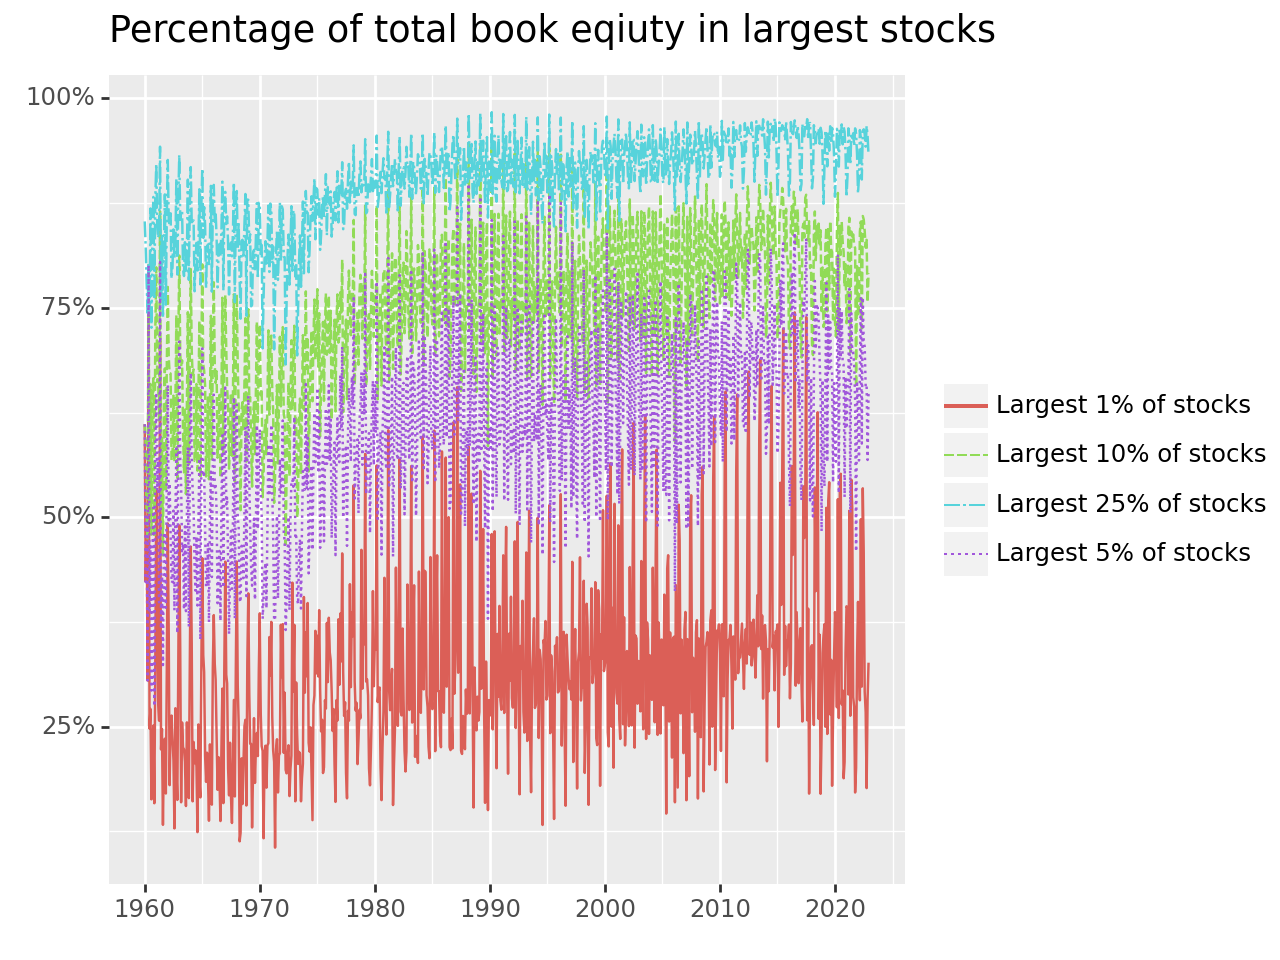

In [19]:
book_equity_concentration = (book_equity
  .groupby("month", group_keys = False)
  .apply(lambda x: x.assign(
    top01=(x["be"] >= np.quantile(x["be"], 0.99)),
    top05=(x["be"] >= np.quantile(x["be"], 0.95)),
    top10=(x["be"] >= np.quantile(x["be"], 0.90)),
    top25=(x["be"] >= np.quantile(x["be"], 0.75)))
  )
  .reset_index(drop=True)
  .groupby("month")
  .apply(lambda x: pd.Series({
    "Largest 1% of stocks": ((x["be"][x["top01"]].sum()) 
                              / x["be"].sum()),
    "Largest 5% of stocks": ((x["be"][x["top05"]].sum()) 
                              / x["be"].sum()),
    "Largest 10% of stocks": ((x["be"][x["top10"]].sum()) 
                              / x["be"].sum()),
    "Largest 25% of stocks": ((x["be"][x["top25"]].sum()) 
                              / x["be"].sum())
    })
  )
  .reset_index()
  .melt(id_vars="month", 
        var_name="name", 
        value_name="value")
)

plot_be_concentration = (
  ggplot(book_equity_concentration, 
         aes(x="month", y="value", 
         color="name", linetype="name")) +
  geom_line() +
  scale_y_continuous(labels=percent_format()) +
  scale_x_date(name="", date_labels="%Y") +
  labs(x="", y="", color="", linetype="", 
       title="Percentage of total book eqiuty in largest stocks") +
  theme(legend_title=element_blank())
)
plot_be_concentration.draw()

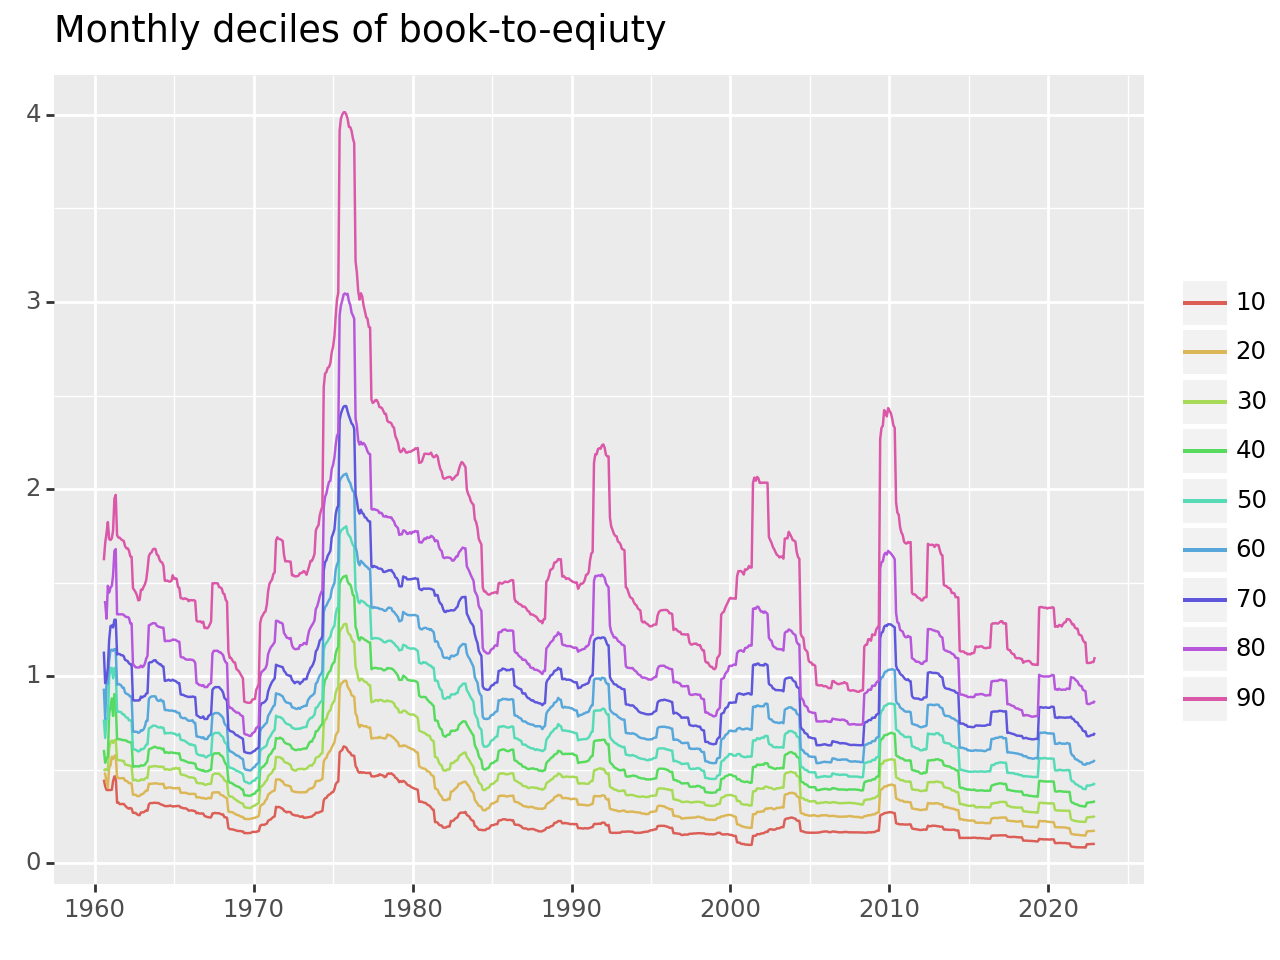

In [20]:
# 绘制断点图---账面市值比
bm_quantiles = (data_for_sorts
  .groupby("month")["bm"]
  .quantile(q=np.arange(0.1, 1.0, 0.1))
  .reset_index()
  .rename(columns={"level_1": "quantile"})
  .assign(
    quantile=lambda x: (x["quantile"] * 100).astype(int)
  )
  .dropna()
)

plot_bm_quantiles = (
  ggplot(bm_quantiles, 
         aes(x="month", y="bm", 
             color="factor(quantile)")) +
  geom_line() +
  scale_x_datetime(breaks=date_breaks("10 year"), 
                   labels=date_format("%Y")) +
  labs(x="", y="", color="",
       title="Monthly deciles of book-to-eqiuty")
)
plot_bm_quantiles.draw()

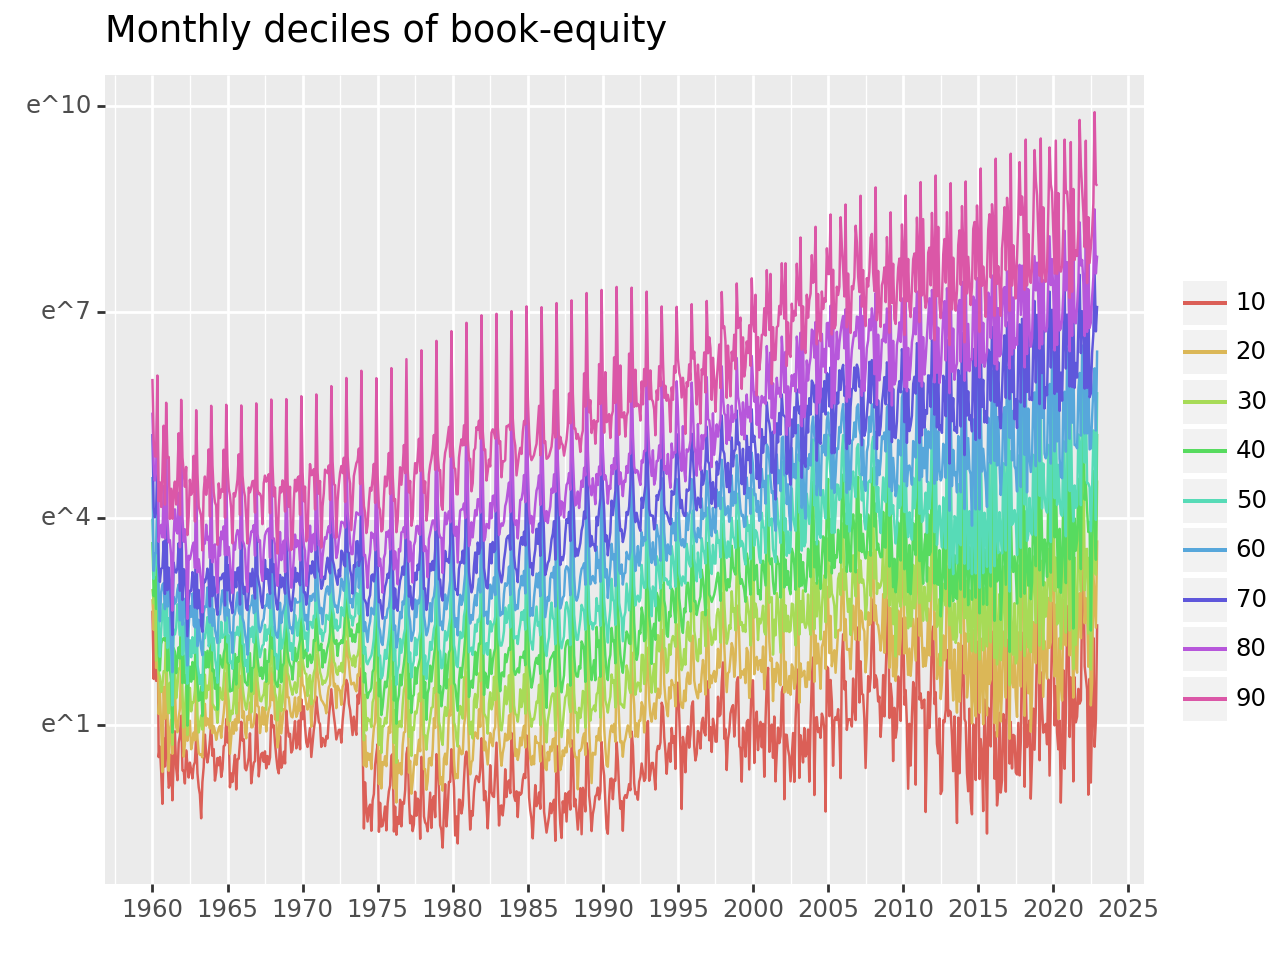

In [21]:
# 绘制断点图---账面值
be_quantiles = (book_equity
  .groupby("month")["be"]
  .quantile(q=np.arange(0.1, 1.0, 0.1))
  .reset_index()
  .rename(columns={"level_1": "quantile"})
  .assign(
    quantile=lambda x: (x["quantile"] * 100).astype(int)
  )
  .dropna()
)

plot_be_quantiles = (
  ggplot(be_quantiles, 
         aes(x="month", y="be", 
             color="factor(quantile)")) +
  geom_line() +
  scale_x_datetime(breaks=date_breaks("5 year"), 
                   labels=date_format("%Y")) +
    scale_y_continuous(trans='log')+
  labs(x="", y="", color="",
       title="Monthly deciles of book-equity")
)
plot_be_quantiles.draw()

#### 练习2
当我们调查投资组合时，我们只关注回报。然而，了解投资组合的特征也很有意义。编写一个函数，计算25个独立和独立排序的投资组合的规模和账面市值的平均特征。

In [22]:
def ave_portfolio_bm_me(data_for_sorts,type):
    if type == "independent": # 如果采用独立排序
        return(data_for_sorts
                     .groupby("month", group_keys=False)
                     .apply(lambda x: x.assign(
         portfolio_bm = assign_portfolio(data=x,sorting_variable="bm",n_portfolios=5,exchanges=["NYSE"]),
         portfolio_me = assign_portfolio(data=x,sorting_variable="me",n_portfolios=5,exchanges=["NYSE"])))
                     .groupby(["month", "portfolio_bm", "portfolio_me"])
                     .apply(lambda x: pd.Series(
         {"ave_bm": np.average(x["bm"]),"ave_me":np.average(x["me"])})) 
                     .reset_index())
    else: # 如果采用从属排序
        return(data_for_sorts
                     .groupby("month", group_keys=False)
                     .apply(lambda x: x.assign(portfolio_me = assign_portfolio(data=x,
                                         sorting_variable="me",
                                         n_portfolios=5,
                                         exchanges=["NYSE"])))
                     .groupby(["month", "portfolio_me"], group_keys=False)
                     .apply(lambda x: x.assign(
         portfolio_bm = assign_portfolio(data=x,
                                         sorting_variable="bm",
                                         n_portfolios=5,
                                         exchanges=["NYSE"])))
                     .groupby(["month", "portfolio_bm", "portfolio_me"])
                     .apply(lambda x: pd.Series(
         {"ave_bm": np.average(x["bm"]),"ave_me":np.average(x["me"])}))
                     .reset_index())

#### 练习三：
至于尺寸溢价，此处构建的价值溢价也不遵循Fama和French(1993)。按照尺寸排序和P-Hacking中的内容实施p-hacking设置，以找到最接近其HML溢价的溢价。

In [23]:
# 定义计算价值溢价函数calculate_value_premium
def calculate_value_premium(n_portfolios1, exchanges1, value_weighted, sorts_method, data1):
    print(f"Calculating for {n_portfolios1=}, {exchanges1=}, {value_weighted=}, {sorts_method=}")
    match sorts_method:
        case "Independent Sorts":
                sorted_portfolios = (data1
                                        .groupby("month", group_keys=False)
                                        .apply(lambda x: x.assign(
                                                portfolio_bm = assign_portfolio(data=x,sorting_variable="bm",
                                                                                n_portfolios=n_portfolios1,
                                                                                exchanges=exchanges1),
                                                portfolio_me = assign_portfolio(data=x,
                                                                                sorting_variable="me",
                                                                                n_portfolios=n_portfolios1,
                                                                                exchanges=exchanges1)))
                                        )
        case _:
                sorted_portfolios = (data1
                                        .groupby("month", group_keys=False)
                                        .apply(lambda x: x.assign(
                                                portfolio_me = assign_portfolio(data=x,
                                                                                sorting_variable="me",
                                                                                n_portfolios=n_portfolios1,
                                                                                exchanges=exchanges1)))
                                        .groupby(["month", "portfolio_me"], group_keys=False)
                                        .apply(lambda x: x.assign(
                                                portfolio_bm = assign_portfolio(data=x,
                                                                                sorting_variable="bm",
                                                                                n_portfolios=n_portfolios1,
                                                                                exchanges=exchanges1)))
                                        )
    value_portfolios = (sorted_portfolios
                        .groupby(["month", "portfolio_bm", "portfolio_me"])
                        .apply(lambda x: pd.Series({"ret": np.where(value_weighted,
                                                        np.average(x["ret_excess"],weights=x["mktcap_lag"]),
                                                        np.mean(x["ret_excess"]))}))
                        .reset_index()
                        )
    value_premium = (value_portfolios
                        .groupby(["month", "portfolio_bm"])
                        .aggregate({"ret": "mean"})
                        .reset_index()
                        .groupby("month")
                        .apply(lambda x: x.assign(min_bm_ret = np.nanmean(x["ret"][x["portfolio_bm"]==x["portfolio_bm"].min()]),
                                                  max_bm_ret = np.nanmean(x["ret"][x["portfolio_bm"]==x["portfolio_bm"].max()])))
                        .assign(value_premium = lambda x: x["max_bm_ret"]-x["min_bm_ret"]) )["value_premium"].mean()
    return value_premium

In [24]:
import itertools
from joblib import Parallel, delayed, cpu_count
n_portfolios = [2, 5, 10]
exchanges = [["NYSE"], ["NYSE", "NASDAQ", "AMEX"]]
value_weighted = [True, False]
sorts_method = ["Independent Sorts", "Dependent Sorts"]
data_filters = [data_for_sorts] # 这里未对数据集的筛选方式进行变动，后续可以补充（由于电脑内存不足）
p_hacking_setup = list(itertools.product(n_portfolios, exchanges, value_weighted, sorts_method, data_filters))
p_hacking_setup[0]

(2,
 ['NYSE'],
 True,
 'Independent Sorts',
          permno   gvkey      month  ret_excess     mktcap_lag             me  \
 14        10000  013007 1987-04-01   -0.066900       0.973250       0.973250   
 15        10000  013007 1987-05-01   -0.070467       0.912422       0.912422   
 26        10001  012994 1986-12-01    0.010100       6.937000       6.937000   
 27        10001  012994 1987-01-01   -0.039914       6.937000       6.937000   
 28        10001  012994 1987-02-01   -0.078374       6.689250       6.689250   
 ...         ...     ...        ...         ...            ...            ...   
 3097032   93436  184996 2022-08-01   -0.074389  931110.623250  931110.623250   
 3097033   93436  184996 2022-09-01   -0.039489  863615.620800  863615.620800   
 3097034   93436  184996 2022-10-01   -0.144468  837659.500000  837659.500000   
 3097035   93436  184996 2022-11-01   -0.147226  718514.868879  718514.868879   
 3097036   93436  184996 2022-12-01   -0.370634  614814.304763  6

In [25]:
n_cores = cpu_count() - 1
p_hacking_results = pd.Series(
  Parallel(n_jobs=n_cores)
  (delayed(calculate_value_premium)(x, y, z, w, v) 
   for x, y, z, w, v in p_hacking_setup)
)

In [26]:
p_hacking_results[0:10]

0    0.002156
1    0.001883
2    0.003223
3    0.003124
4    0.003615
5    0.003116
6    0.004192
7    0.004016
8    0.004312
9    0.003804
dtype: float64

In [27]:
data_filters = ["crsp_monthly"]
p_hacking_setup = pd.DataFrame(list(itertools.product(n_portfolios, exchanges, value_weighted, sorts_method, data_filters)))
p_hacking_setup["value_premium"] = p_hacking_results
p_hacking_exhibit= (p_hacking_setup
                    .rename(columns={0:"n_portfolio_choice",
                                     1:"exchanges_choice",
                                     2:"value_weighted_choice",
                                     3:"sots_method_choice",
                                     4:"data_chioce"}))
p_hacking_exhibit.head(10)

,n_portfolio_choice,exchanges_choice,value_weighted_choice,sots_method_choice,data_chioce,value_premium
0,2,[NYSE],True,Independent Sorts,crsp_monthly,0.002156
1,2,[NYSE],True,Dependent Sorts,crsp_monthly,0.001883
2,2,[NYSE],False,Independent Sorts,crsp_monthly,0.003223
3,2,[NYSE],False,Dependent Sorts,crsp_monthly,0.003124
4,2,"[NYSE, NASDAQ, AMEX]",True,Independent Sorts,crsp_monthly,0.003615
5,2,"[NYSE, NASDAQ, AMEX]",True,Dependent Sorts,crsp_monthly,0.003116
6,2,"[NYSE, NASDAQ, AMEX]",False,Independent Sorts,crsp_monthly,0.004192
7,2,"[NYSE, NASDAQ, AMEX]",False,Dependent Sorts,crsp_monthly,0.004016
8,5,[NYSE],True,Independent Sorts,crsp_monthly,0.004312
9,5,[NYSE],True,Dependent Sorts,crsp_monthly,0.003804


In [28]:
factors_ff3_monthly = pd.read_sql_query(sql='SELECT month, mkt_excess hml FROM factors_ff3_monthly',
                                        con=tidy_finance,parse_dates={'month'}).dropna()

In [29]:
p_hacking_exhibit["ff_hml"]  = (factors_ff3_monthly)["hml"].mean()

In [30]:
(p_hacking_exhibit
 .assign(difference = lambda x: abs(x["ff_hml"]-x["value_premium"])) # 市账比溢价与ff的hml溢价求差
 .sort_values("difference")).head(10)

,n_portfolio_choice,exchanges_choice,value_weighted_choice,sots_method_choice,data_chioce,value_premium,ff_hml,difference
16,10,[NYSE],True,Independent Sorts,crsp_monthly,0.004760,0.005457,0.000697
18,10,[NYSE],False,Independent Sorts,crsp_monthly,0.004651,0.005457,0.000806
10,5,[NYSE],False,Independent Sorts,crsp_monthly,0.004438,0.005457,0.001019
8,5,[NYSE],True,Independent Sorts,crsp_monthly,0.004312,0.005457,0.001145
19,10,[NYSE],False,Dependent Sorts,crsp_monthly,0.004282,0.005457,0.001175
6,2,"[NYSE, NASDAQ, AMEX]",False,Independent Sorts,crsp_monthly,0.004192,0.005457,0.001265
14,5,"[NYSE, NASDAQ, AMEX]",False,Independent Sorts,crsp_monthly,0.006742,0.005457,0.001285
13,5,"[NYSE, NASDAQ, AMEX]",True,Dependent Sorts,crsp_monthly,0.006780,0.005457,0.001323
22,10,"[NYSE, NASDAQ, AMEX]",False,Independent Sorts,crsp_monthly,0.006791,0.005457,0.001334
15,5,"[NYSE, NASDAQ, AMEX]",False,Dependent Sorts,crsp_monthly,0.006802,0.005457,0.001345


可以看到，分组为5组、确定断点的证券交易所为纽约证券交易所、加权规则为市值加权、排序方式为独立排序，产生的市账比溢价与与Fama French规则计算出的价值溢价最接近